In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import h5py
import os
from scipy.stats import norm, halfnorm
import stan
import arviz as az
from mcmc_functions import single_logit, general_logit

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
project_dir = '/data/florican/jamiesonball/Intern_Project'

data_dir = os.path.join(project_dir, 'data')
data_filepath = os.path.join(data_dir, 'BGD_daily_inc_fatalities.h5')

data = pd.read_hdf(data_filepath,
                   key='event_data')

KeyboardInterrupt: 

In [ ]:
data['DATE'] =  pd.to_datetime(data['YEAR'].astype(int).astype(str) + data['DAY'].astype(int).astype(str), format='%Y%j')
data['MONTH'] = data['DATE'].dt.to_period ('M')
data['WEEK'] = data['DATE'].dt.to_period('W')

dhaka_battles = data.loc[data['ADM2_name'] == 'Dhaka'].loc[data['EVENT_TYPE'] == 'Battles'].groupby('WEEK', as_index=False)[['RAW_COUNTS', 'FATALITIES']].sum()
dhaka_battles['BOOLEAN_FATAL'] = dhaka_battles['FATALITIES'].astype('bool').astype('int')
dhaka_battles['PREV_WEEK'] = (dhaka_battles['BOOLEAN_FATAL'].shift(1) > 0).astype(int)

bins = [0, 1, 2, 3, float('inf')]
dhaka_battles['BINS'] = pd.cut(dhaka_battles['RAW_COUNTS'], bins = bins, right=False, labels=range(4))

In [ ]:
dhaka_battles

,WEEK,RAW_COUNTS,FATALITIES,BOOLEAN_FATAL,PREV_WEEK,BINS
0,2009-12-28/2010-01-03,1.0,0.0,0,0,1
1,2010-01-04/2010-01-10,1.0,1.0,1,0,1
2,2010-01-11/2010-01-17,0.0,0.0,0,1,0
3,2010-01-18/2010-01-24,1.0,0.0,0,0,1
4,2010-01-25/2010-01-31,0.0,0.0,0,0,0
...,...,...,...,...,...,...
622,2021-11-29/2021-12-05,0.0,0.0,0,0,0
623,2021-12-06/2021-12-12,0.0,0.0,0,0,0
624,2021-12-13/2021-12-19,0.0,0.0,0,0,0
625,2021-12-20/2021-12-26,0.0,0.0,0,0,0


In [ ]:
import nest_asyncio
nest_asyncio.apply()

# Using Stan to sample

In this notebook the same models are repeated, using Stan to sample from the posterior distributions for a faster and better sampling. Stan uses Hamiltonian Monte Carlo which uses the concept of a Hamiltonian dynamic system to simulate the movement of the Markov Chain in the parameter space. In the language of Hamiltonian dynamics, the current state of the Markov chain is represented by the "position" of a "particle" in the parameter space, and the "momentum" acts as a guide to aid in the exploration of the parameter space. In addition, Stan uses a No U-Turn Sampler to avoid resampling areas of the posterior distribution, which is designed to improve the effective sample size and reduce the autocorrelation of the sample.

## Model 1: logistic regression on the number of events

The first model that is considered is a logistic regression model on the number of battles in a week. The model is given as the following logistic regression equation

\begin{equation}
    p_i = p(S_i) = \frac{\exp(\alpha + \beta S_i)}{1+\exp(\alpha + \beta S_i)}
\end{equation}

where $p(S_i)$ is the proportion of weeks with $S_i$ battles which have an associated fatality. Normal priors are set for $\alpha$ and $\beta$, with $\alpha \sim N(0, v_\alpha^2)$ and $\beta \sim N(0, v_\beta^2)$.

The fatality indicators $F_i \sim Bern(p_i)$ with $p_i$ being given by the logistic regression equation, leading to the likelihood function being 

\begin{equation}
    L(F; \alpha, \beta) = \prod_{i=1}^N p_i^{F_i} (1-p_i)^{1-F_i}
\end{equation}

with associated log likelihood

\begin{equation}
    l(F; \alpha, \beta) = \sum_{i=1}^N \left(F_i \log(p_i) + (1-F_i) \log(1-p_i)\right).
\end{equation}

### Sampling

The Stan code for this model can be found in the folder `stan_files` in the file `model1.stan`. This is called in the cell below which builds the model.

In [ ]:
stan_filepath = 'stan_files/model1.stan'
with open(stan_filepath) as f:
    model1_stan = f.read()

fatality_flag = dhaka_battles['BOOLEAN_FATAL'].values
event_counts = dhaka_battles['RAW_COUNTS'].values
num_obs = len(fatality_flag)

model1_data = {'fatality_flag':fatality_flag,
               'event_counts':event_counts,
               'num_obs':num_obs}

In [ ]:
model1_stan

'data {\n    int<lower=0> num_obs;                                       // number of observations\n    vector[num_obs] event_counts;                               // number of events\n    array[num_obs] int<lower=0,upper=1> fatality_flag;         // fatality indicator\n}\n\nparameters{\n    real alpha;\n    real beta_;\n}\n\nmodel{\n    // priors\n    alpha ~ normal(0, 1);\n    beta_ ~ normal(0, 1);\n\n    // likelihood\n    fatality_flag ~ bernoulli_logit(alpha + beta_ * event_counts);\n}'

In [ ]:
model1 = stan.build(model1_stan,
                   data=model1_data,
                   random_seed=1)

Building...



Building: found in cache, done.

In [ ]:
model1_stan

'data {\n    int<lower=0> num_obs;                                       // number of observations\n    vector[num_obs] event_counts;                               // number of events\n    array[num_obs] int<lower=0,upper=1> fatality_flag;         // fatality indicator\n}\n\nparameters{\n    real alpha;\n    real beta_;\n}\n\nmodel{\n    // priors\n    alpha ~ normal(0, 1);\n    beta_ ~ normal(0, 1);\n\n    // likelihood\n    fatality_flag ~ bernoulli_logit(alpha + beta_ * event_counts);\n}'

In [ ]:
num_samples = 10000
num_chains = 4
num_warmup = 2000
num_thin = 10
refresh = 1000
delta = 0.8

In [ ]:
model1_samples = model1.sample(num_samples=num_samples,
                        num_chains=num_chains,
                        num_warmup=num_warmup,
                        num_thin=num_thin,
                        refresh=refresh,
                        delta=delta)

Sampling:   0%
Sampling:   0% (1/48000)
Sampling:   2% (1001/48000)
Sampling:   4% (2001/48000)
Sampling:  29% (14001/48000)
Sampling:  54% (26000/48000)
Sampling:  77% (37000/48000)
Sampling: 100% (48000/48000)
Sampling: 100% (48000/48000), done.
Messages received during sampling:
  Gradient evaluation took 0.000185 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000154 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000137 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.37 seconds.
  Adjust your expectations accordingly!


In [ ]:
model1_df = model1_samples.to_frame()

In [ ]:
type(model1_samples)

stan.fit.Fit

In [ ]:
model1_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_
draws,,,,,,,,,
0,-90.941442,0.988626,0.524636,4.0,15.0,0.0,91.112871,-3.514710,2.722941
1,-90.614116,0.983404,0.453002,3.0,7.0,0.0,92.782347,-3.556472,3.023521
2,-89.735968,0.973037,0.510798,1.0,3.0,0.0,90.256515,-3.926493,3.280525
3,-91.223702,0.896982,0.534585,2.0,7.0,0.0,91.708617,-3.985288,3.639836
4,-90.082133,0.889554,0.524636,2.0,3.0,0.0,91.212075,-3.662896,3.066209
...,...,...,...,...,...,...,...,...,...
3995,-90.640478,0.953202,0.534585,2.0,5.0,0.0,91.057934,-4.255649,3.610101
3996,-90.261093,0.886566,0.524636,2.0,7.0,0.0,90.900037,-3.623951,2.869239
3997,-90.068644,0.974595,0.453002,2.0,3.0,0.0,90.099867,-3.940220,3.412998


Effective sample size of 3858.7104909514765 for parameter alpha
Effective sample size of 3791.1679119392743 for parameter beta_


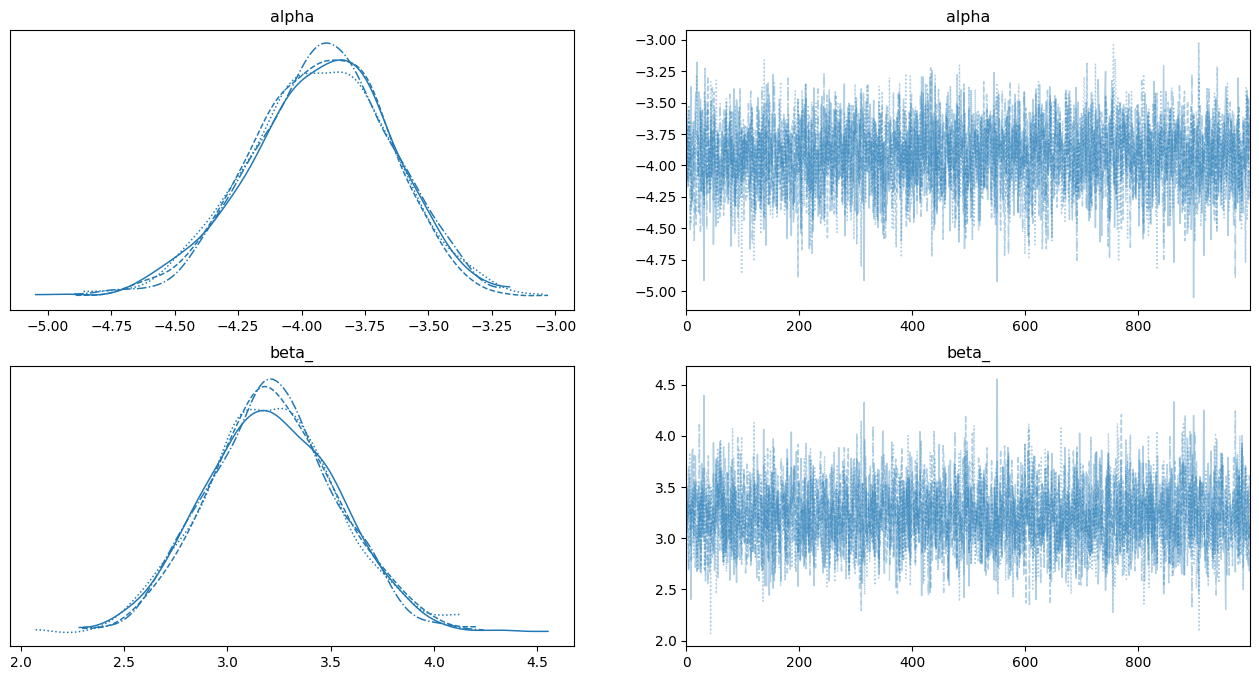

In [ ]:
params = ['alpha', 'beta_']

for param in params:
    ess = az.ess(model1_df[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

az.plot_trace(model1_samples, figsize=(16,8))
plt.show()

The trace plots show that the four chains sampled by the sampler traverse the sample space well. Their distribution plots on the left hand side show that the chains line up well with one another. Furthermore, since priors of $\mathrm{N}(0,1)$ were applied to both the $\alpha$ and the $\beta$ parameter, this shows that the information has had an effect on the positions of the posterior distributions, and the sampler is not just sampling the prior. The high effective sample sizes provide further reassurance that the sampling has been performed well and that the samples can be taken forwards as independent samples from the posterior distributions of the parameters.

### Posterior analysis

Like in the MH-MCMC document, I will now plot the logistic regression $p(S_i)$ using the sampled parameters.

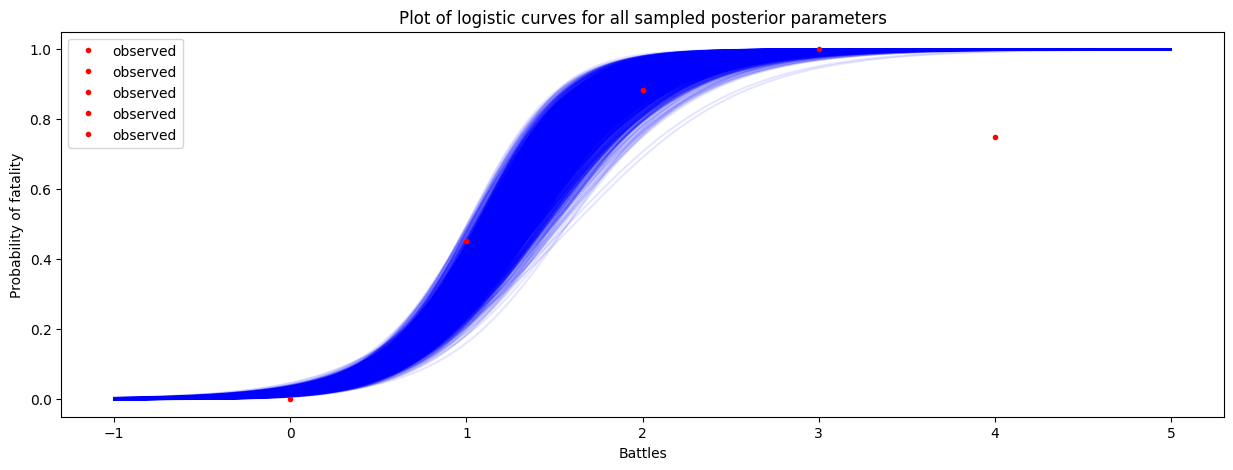

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

for i, alpha in enumerate(model1_df['alpha']):
    beta = model1_df['beta_'][i]
    probs = single_logit(x_axis, [alpha, beta])
    ax.plot(x_axis, probs, c='b', alpha=0.1)

for i in range(5):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')
    
ax.set(xlabel='Battles',
       ylabel='Probability of fatality',
       title='Plot of logistic curves for all sampled posterior parameters')

ax.legend(loc = 'best')

plt.show()

This plot shows that the logistic regression fits the observed data fairly well. The main thing to notice is that the observed data point at $4$ weekly battles is not well represented by the sampled curves themselves, and this is further seen in the violin and box plots below.

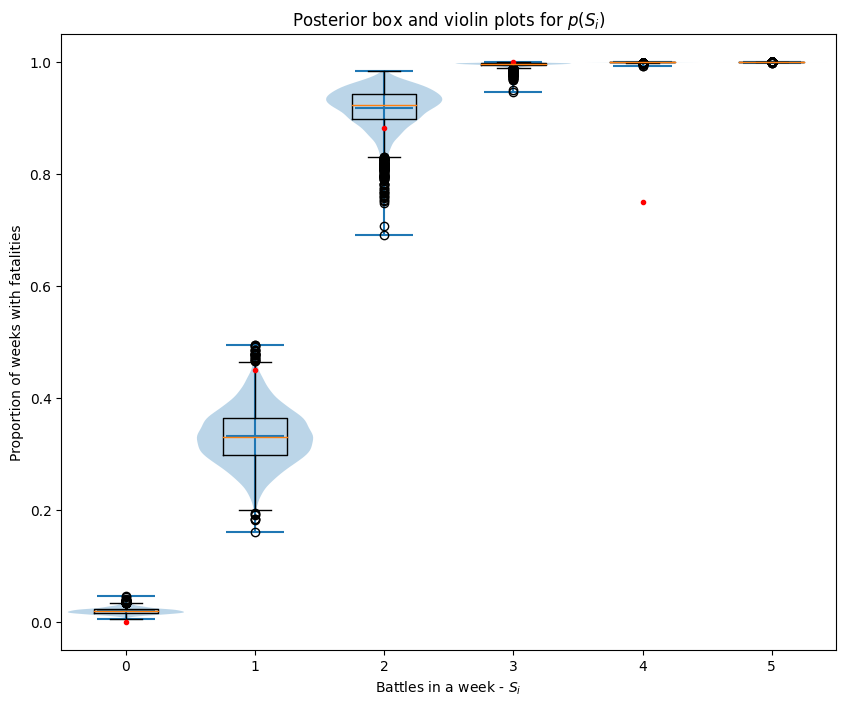

In [ ]:
sim_battles = [0, 1, 2, 3, 4, 5]

results_mat = np.zeros((len(model1_df['alpha']), 6))

for i, alpha in enumerate(model1_df['alpha']):
    beta = model1_df['beta_'][i]
    for j in range(6):
        results_mat[i, j] = single_logit(j, [alpha, beta])

fig, ax = plt.subplots(figsize = (10, 8))

ax.violinplot(results_mat, widths=0.9, showmeans=True, positions=sim_battles)
ax.boxplot(results_mat, widths=0.5, positions=sim_battles)

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')

ax.set(title=r'Posterior box and violin plots for $p(S_i)$',
       xlabel = r'Battles in a week - $S_i$',
       ylabel = 'Proportion of weeks with fatalities')

plt.show()

From these plots it is clear to see that whilst (apart from for $4$ battles) the posterior distributions do include the observations, the observations mostly lie on the tails of the distributions. The sampled posterior probabilities represent the probability that a particular week had a fatality, given a number of battles. Therefore, given a number of weeks with a certain number of battles, the posterior probability can be used as the probability of a Binomial distribution to simulate a number of weeks seeing a fatality, which then very easily leads to a proportion. Repeating this for all posterior samples taken will then more accurately reflect the uncertainty in a real-world observation and may provide better predictive intervals.

To make this clearer, I will run the following algorithm to create these posterior predictive intervals.

1. For each $k=1,2,3,4,\dots$ let $N_k$ be the observed number of weeks with $k$ events.
2. For each $\alpha, \beta$ find $p_k$ using the logistic function.
3. Draw $F_k \sim \mathrm{Binom}(N_k, p_k)$.
4. Record the proportion $\frac{F_k}{N_k}$.

This algorithm is implemented below, the results being stored in a matrix and then violin plots being plotted.

In [ ]:
proportion_mat = np.zeros((len(model1_df), 4))

for idx, alpha in enumerate(model1_df['alpha'].values):
    beta = model1_df['beta_'][idx]
    for count in range(1,5):
        prob = single_logit(count, [alpha, beta])
        num_weeks = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == count]['FATALITIES'].values)
        bin_draw = np.random.binomial(num_weeks, prob)
        proportion_mat[idx, count-1] = bin_draw/num_weeks

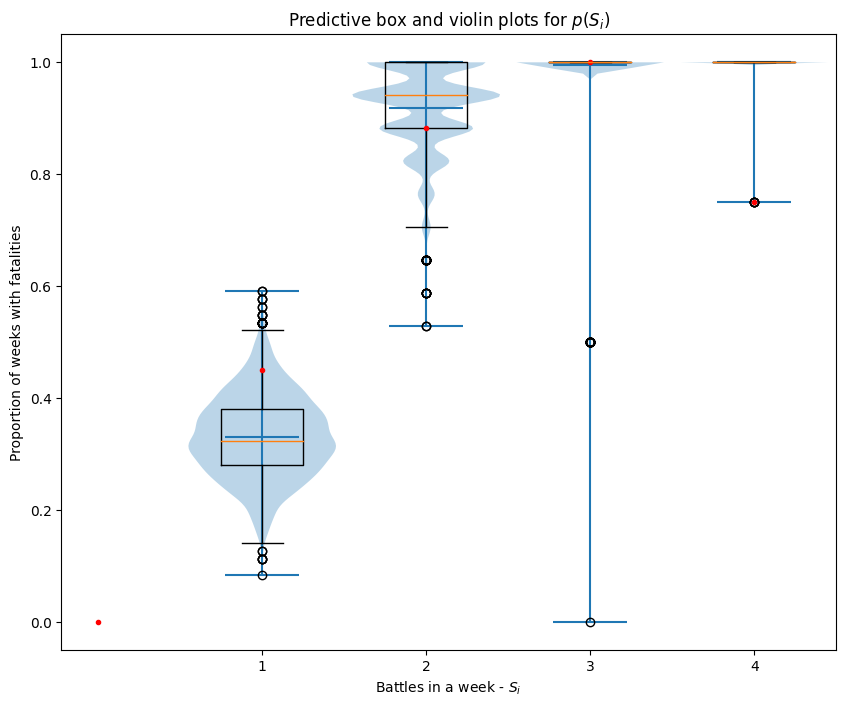

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))

ax.violinplot(proportion_mat, widths=0.9, showmeans=True, positions=[1, 2, 3, 4])
ax.boxplot(proportion_mat, widths=0.5, positions=[1, 2, 3, 4])

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')

ax.set(title=r'Predictive box and violin plots for $p(S_i)$',
       xlabel = r'Battles in a week - $S_i$',
       ylabel = 'Proportion of weeks with fatalities')

plt.show()

## Model 1a: ignoring weeks with no events

A suggested way to reduce the posterior probability of a fatality with zero events is to remove these from the dataset. This is implemented below.

In [ ]:
stan_filepath = 'stan_files/model1.stan'
with open(stan_filepath) as f:
    model1_stan = f.read()

dhaka_battles_only_events = dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] != 0]

fatality_flag_only_events = dhaka_battles_only_events['BOOLEAN_FATAL'].values
event_counts_only_events = dhaka_battles_only_events['RAW_COUNTS'].values
num_obs = len(fatality_flag_only_events)

model1a_data = {'fatality_flag':fatality_flag_only_events,
               'event_counts':event_counts_only_events,
               'num_obs':num_obs}


In [ ]:
model1a = stan.build(model1_stan,
                   data=model1a_data,
                   random_seed=1)

Building...



Building: found in cache, done.

In [ ]:
model1a_samples = model1a.sample(num_samples=num_samples,
                        num_chains=num_chains,
                        num_warmup=num_warmup,
                        num_thin=num_thin,
                        refresh=refresh,
                        delta=delta)

Sampling:   0%
Sampling:  25% (12000/48000)
Sampling:  50% (24000/48000)
Sampling:  75% (36000/48000)
Sampling:  77% (37000/48000)
Sampling: 100% (48000/48000)
Sampling: 100% (48000/48000), done.
Messages received during sampling:
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.36 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.42 seconds.
  Adjust your expectations accordingly!


In [ ]:
model1a_df = model1a_samples.to_frame()

Effective sample size of 4017.0743714174446 for parameter alpha
Effective sample size of 4051.8673211051405 for parameter beta_


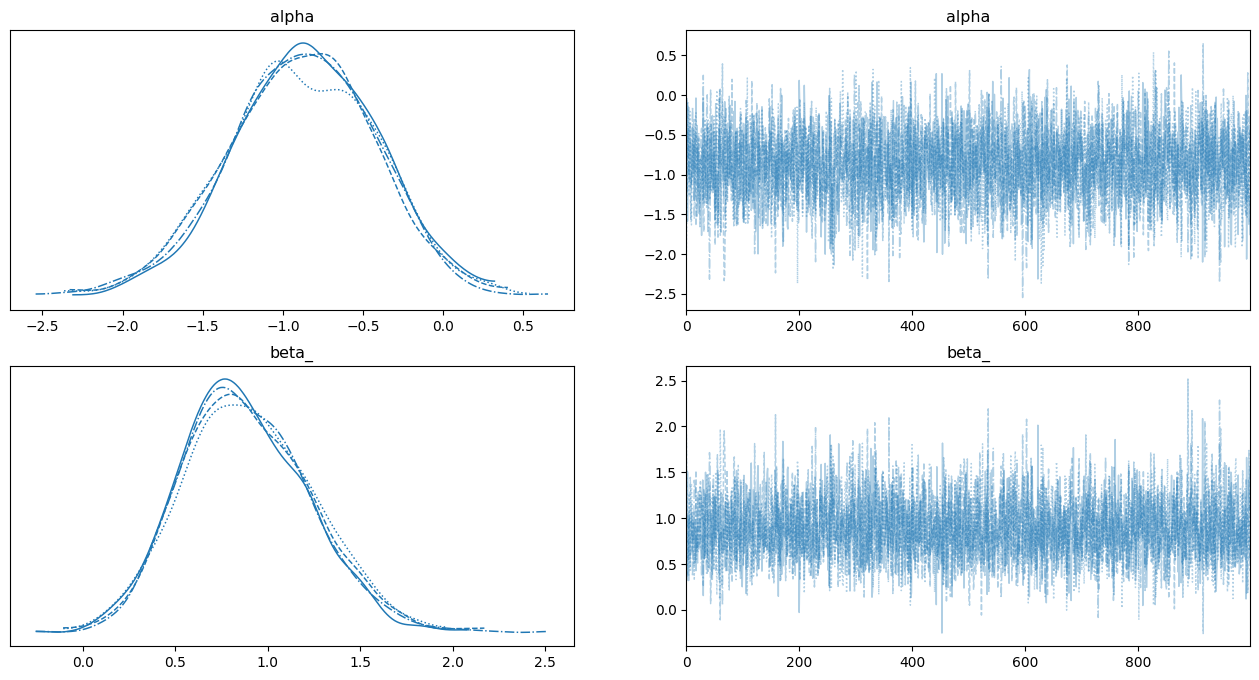

In [ ]:
params = ['alpha', 'beta_']

for param in params:
    ess = az.ess(model1a_df[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

az.plot_trace(model1a_samples, figsize=(16,8))
plt.show()

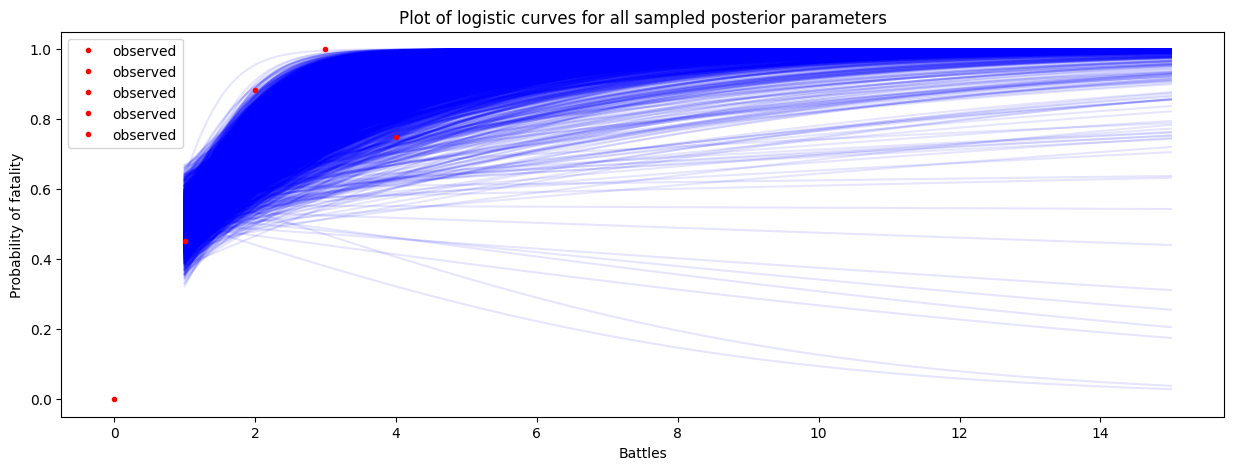

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

x_axis = np.linspace(1, 15, 1000)
event_counts = np.linspace(-1, 5, 7)

for i, alpha in enumerate(model1a_df['alpha']):
    beta = model1a_df['beta_'][i]
    probs = single_logit(x_axis, [alpha, beta])
    ax.plot(x_axis, probs, c='b', alpha=0.1)

for i in range(5):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')
    
ax.set(xlabel='Battles',
       ylabel='Probability of fatality',
       title='Plot of logistic curves for all sampled posterior parameters')

ax.legend(loc = 'best')

plt.show()

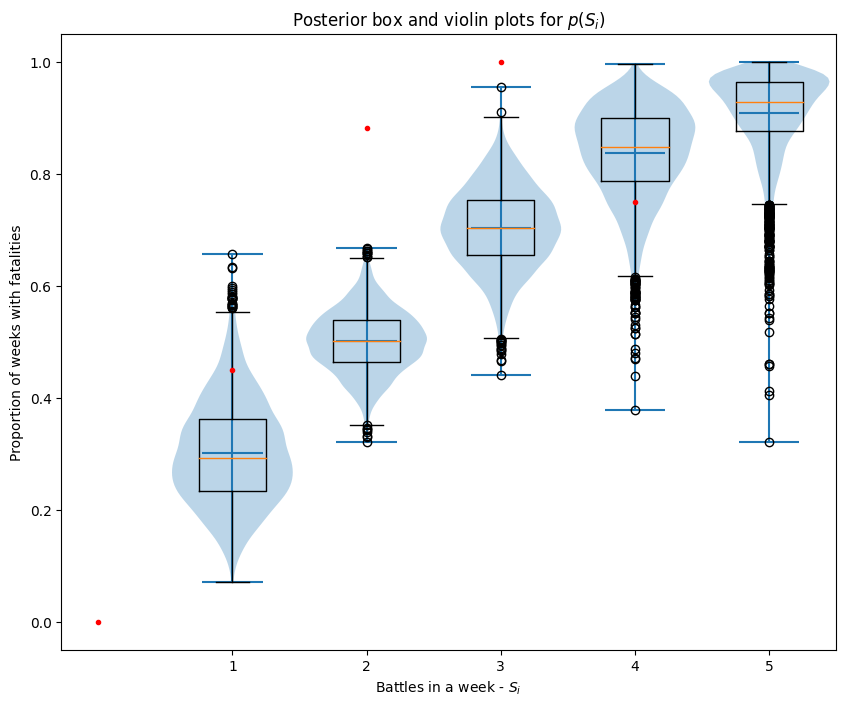

In [ ]:
sim_battles = [1, 2, 3, 4, 5]

results_mat = np.zeros((len(model1a_df['alpha']), 5))

for i, alpha in enumerate(model1a_df['alpha']):
    beta = model1a_df['beta_'][i]
    for j in range(5):
        results_mat[i, j] = single_logit(j, [alpha, beta])

fig, ax = plt.subplots(figsize = (10, 8))

ax.violinplot(results_mat, widths=0.9, showmeans=True, positions=sim_battles)
ax.boxplot(results_mat, widths=0.5, positions=sim_battles)

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')

ax.set(title=r'Posterior box and violin plots for $p(S_i)$',
       xlabel = r'Battles in a week - $S_i$',
       ylabel = 'Proportion of weeks with fatalities')

plt.show()

## Model 2

In [ ]:
stan_filepath = 'stan_files/model2.stan'
with open(stan_filepath) as f:
    model2_stan = f.read()

fatality_flag = dhaka_battles['BOOLEAN_FATAL'].values[1:]
event_counts = dhaka_battles['RAW_COUNTS'].values[1:]
prev_fatality_flag = dhaka_battles['PREV_WEEK'].values[1:]
num_obs = len(fatality_flag)

model2_data = {'fatality_flag':fatality_flag,
               'event_counts':event_counts,
               'num_obs':num_obs,
               'prev_fatality_flag':prev_fatality_flag}


In [ ]:
model2 = stan.build(model2_stan,
                   data=model2_data,
                   random_seed=1)

Building...



Building: found in cache, done.

In [ ]:
model2_samples = model2.sample(num_samples=num_samples,
                        num_chains=num_chains,
                        num_warmup=num_warmup,
                        num_thin=num_thin,
                        refresh=refresh,
                        delta=delta)

Sampling:   0%
Sampling:   0% (1/48000)
Sampling:   0% (2/48000)
Sampling:   0% (3/48000)
Sampling:   0% (4/48000)
Sampling:  25% (12003/48000)
Sampling:  50% (24002/48000)
Sampling:  75% (36001/48000)
Sampling: 100% (48000/48000)
Sampling: 100% (48000/48000), done.
Messages received during sampling:
  Gradient evaluation took 0.000179 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000215 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000191 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.91 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000219 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.19 seconds.
  Adjust your expectations accordingly!


In [ ]:
model2_df = model2_samples.to_frame()

Effective sample size of 3615.8892854721175 for parameter alpha
Effective sample size of 3600.0753094187335 for parameter beta_
Effective sample size of 4149.8592611761 for parameter gamma_


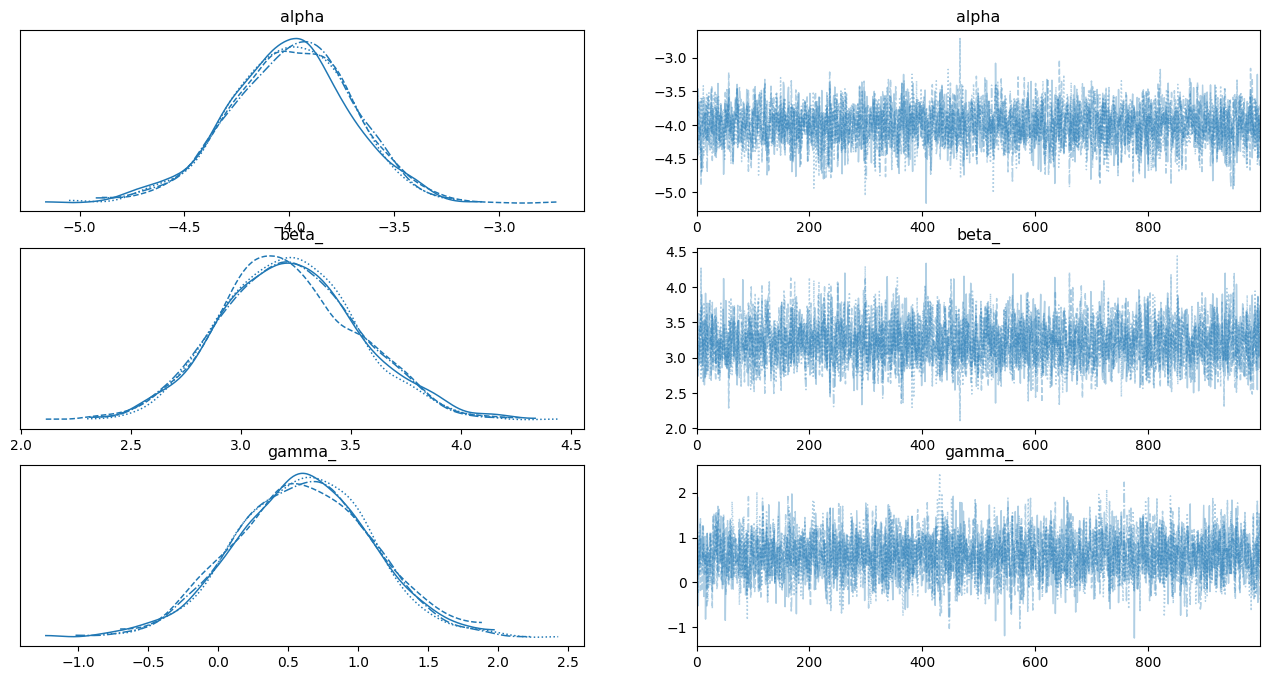

In [ ]:
params = ['alpha', 'beta_', 'gamma_']

for param in params:
    ess = az.ess(model2_df[param].values)
    print(f'Effective sample size of {ess} for parameter {param}')

az.plot_trace(model2_samples, figsize=(16,8))
plt.show()

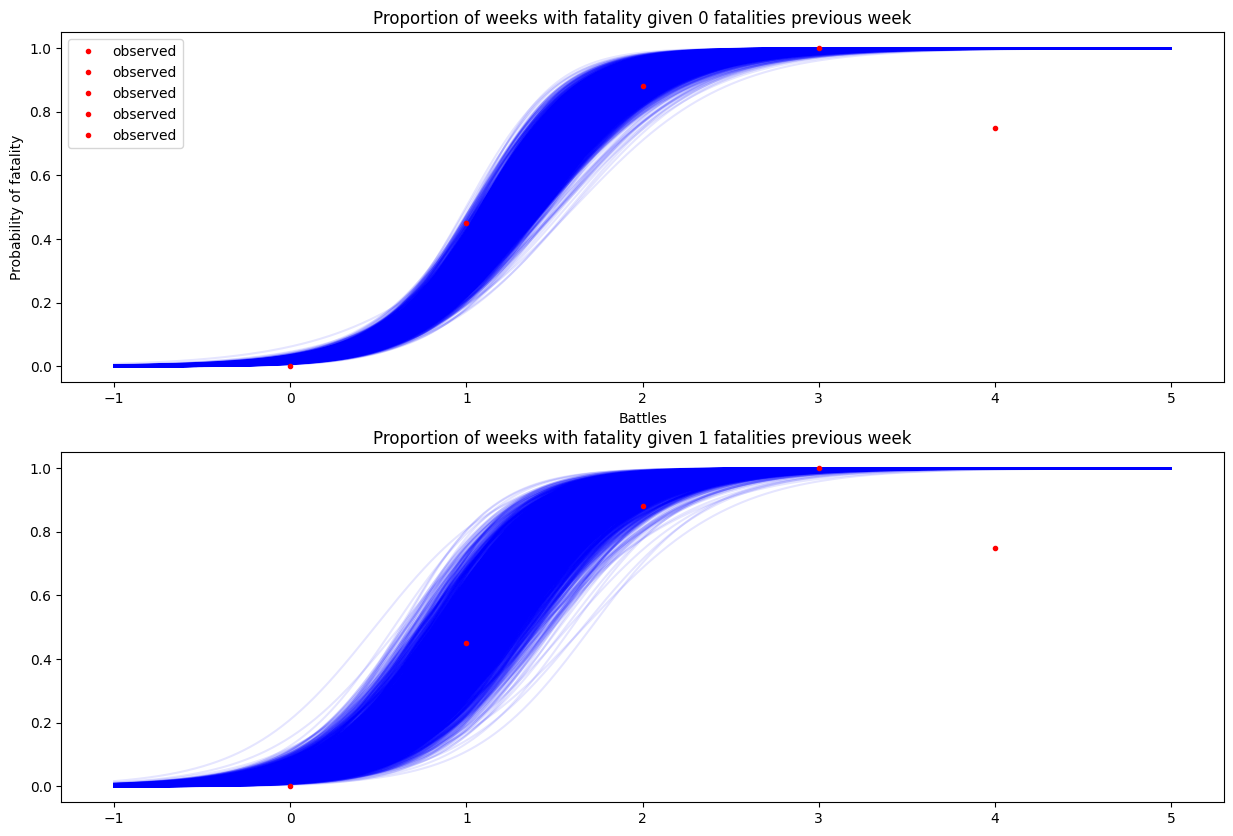

In [ ]:
fig, ax = plt.subplots(2, figsize = (15, 10))

x_axis = np.linspace(-1, 5, 1000)
event_counts = np.linspace(-1, 5, 7)

for idx in range(2):
    for i, alpha in enumerate(model2_df['alpha']):
        beta = model2_df['beta_'][i]
        gamma = model2_df['gamma_'][i]
        probs = general_logit([x_axis, idx], [alpha, beta, gamma])
        ax[idx].plot(x_axis, probs, c='b', alpha=0.1)
    ax[idx].set(title = f'Proportion of weeks with fatality given {idx} fatalities previous week')

for i in range(5):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax[0].plot(i, fatal/total, 'r.', label='observed')
        ax[1].plot(i, fatal/total, 'r.', label='observed')
    
ax[0].set(xlabel='Battles',
       ylabel='Probability of fatality')

ax[0].legend(loc = 'best')

plt.show()

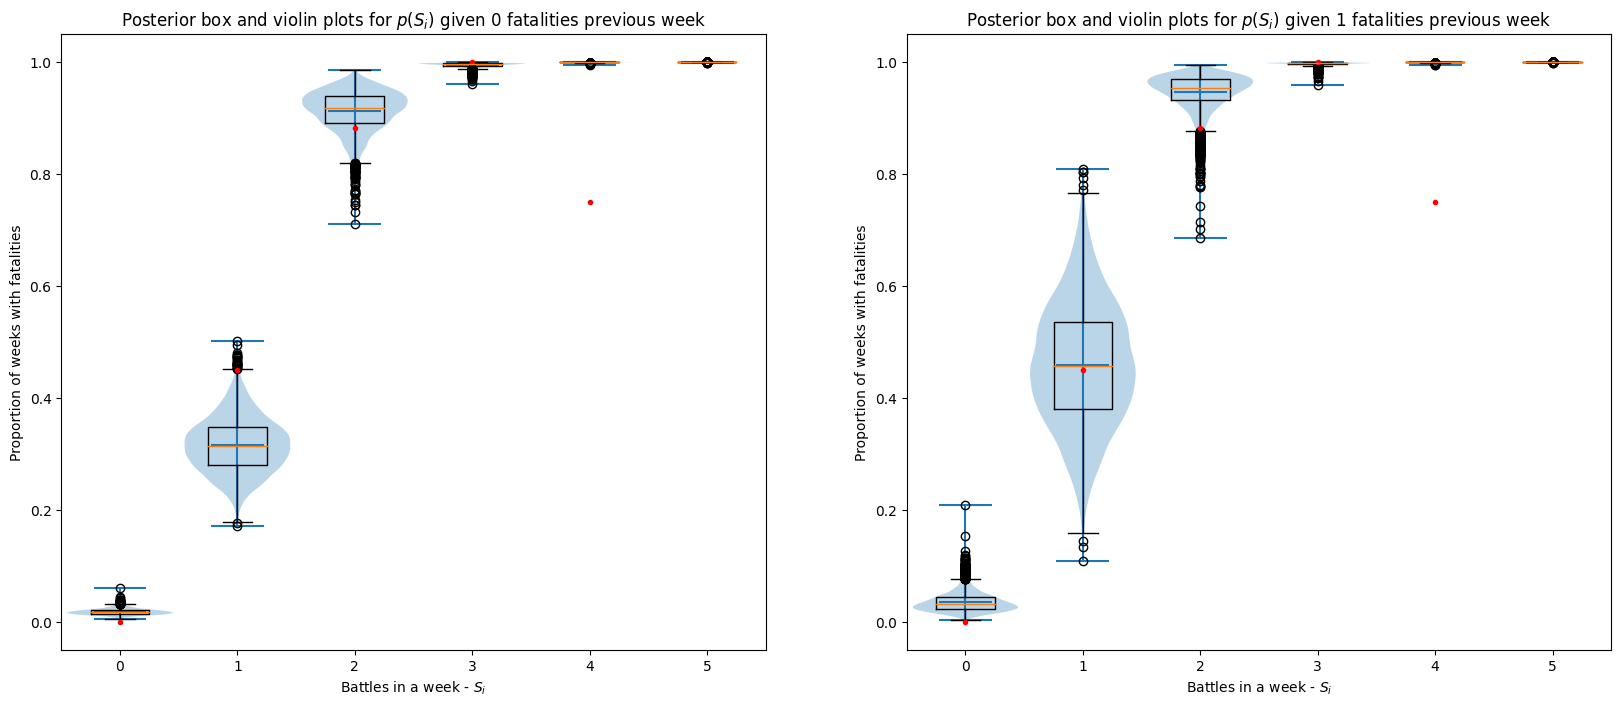

In [ ]:
sim_battles = [0, 1, 2, 3, 4, 5]

results_mat0 = np.zeros((len(model2_df['alpha']), 6))
results_mat1 = np.zeros((len(model2_df['alpha']), 6))

for i, alpha in enumerate(model2_df['alpha']):
    beta = model2_df['beta_'][i]
    gamma = model2_df['gamma_'][i]
    for j in range(6):
        results_mat0[i, j] = general_logit([j, 0], [alpha, beta, gamma])
        results_mat1[i, j] = general_logit([j, 1], [alpha, beta, gamma])

fig, ax = plt.subplots(1, 2, figsize = (20, 8))

results = [results_mat0, results_mat1]

for i in range(2):
    ax[i].violinplot(results[i], widths=0.9, showmeans=True, positions=sim_battles)
    ax[i].boxplot(results[i], widths=0.5, positions=sim_battles)
    ax[i].set(title=rf'Posterior box and violin plots for $p(S_i)$ given {i} fatalities previous week',
              xlabel = r'Battles in a week - $S_i$',
              ylabel = 'Proportion of weeks with fatalities')

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['RAW_COUNTS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax[0].plot(i, fatal/total, 'r.', label='observed')
        ax[1].plot(i, fatal/total, 'r.', label='observed')



plt.show()

## Model 4: stick breaking

In [ ]:
stan_filepath = 'stan_files/model4_archive.stan'
with open(stan_filepath) as f:
    old_model4_stan = f.read()

stan_filepath = 'stan_files/model4.stan'
with open(stan_filepath) as f:
    model4_stan = f.read()

fatality_flag = dhaka_battles['BOOLEAN_FATAL'].values
event_bins = dhaka_battles['BINS'].values.astype(int)
num_obs = len(fatality_flag)

model4_data = {'fatality_flag':fatality_flag,
               'event_bins':event_bins,
               'num_obs':num_obs,
               'max_events':3}

In [ ]:
model4 = stan.build(model4_stan,
                     data=model4_data,
                     random_seed=1)

Building...



Building: found in cache, done.

In [ ]:
model4_samples = model4.sample(num_samples=num_samples,
                        num_chains=num_chains,
                        num_warmup=num_warmup,
                        num_thin=num_thin,
                        refresh=refresh,
                        delta=delta)

Sampling:   0%
Sampling:   2% (1000/48000)
Sampling:   8% (4000/48000)
Sampling:  33% (16000/48000)
Sampling:  58% (28000/48000)
Sampling:  81% (39000/48000)
Sampling: 100% (48000/48000)
Sampling: 100% (48000/48000), done.
Messages received during sampling:
  Gradient evaluation took 8.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.85 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.64 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!


In [ ]:
model4_df = model4_samples.to_frame()

In [ ]:
model4_df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,pK,q.1,q.2,p.1,p.2
draws,,,,,,,,,,,,
0,-64.766388,0.997530,0.404313,2.0,3.0,0.0,64.945517,0.918351,0.534956,0.847948,0.416578,0.778714
1,-65.441756,0.999832,0.423191,2.0,3.0,0.0,65.506245,0.768310,0.688927,0.930083,0.492301,0.714591
2,-65.293884,0.991696,0.389390,2.0,7.0,0.0,65.604641,0.876780,0.589500,0.967042,0.499827,0.847883
3,-69.159638,0.907531,0.405449,3.0,7.0,0.0,70.311221,0.924234,0.489495,0.999030,0.451969,0.923337
4,-66.410656,0.497949,0.404313,2.0,3.0,0.0,67.546791,0.933182,0.629943,0.931523,0.547597,0.869280
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-65.829988,0.856833,0.405449,3.0,7.0,0.0,66.619643,0.928464,0.462356,0.968491,0.415755,0.899209
3996,-65.593572,0.966946,0.404313,2.0,3.0,0.0,65.768870,0.896231,0.710857,0.751889,0.479023,0.673866
3997,-64.935245,0.971486,0.423191,3.0,15.0,0.0,66.576298,0.810291,0.568029,0.961847,0.442708,0.779376


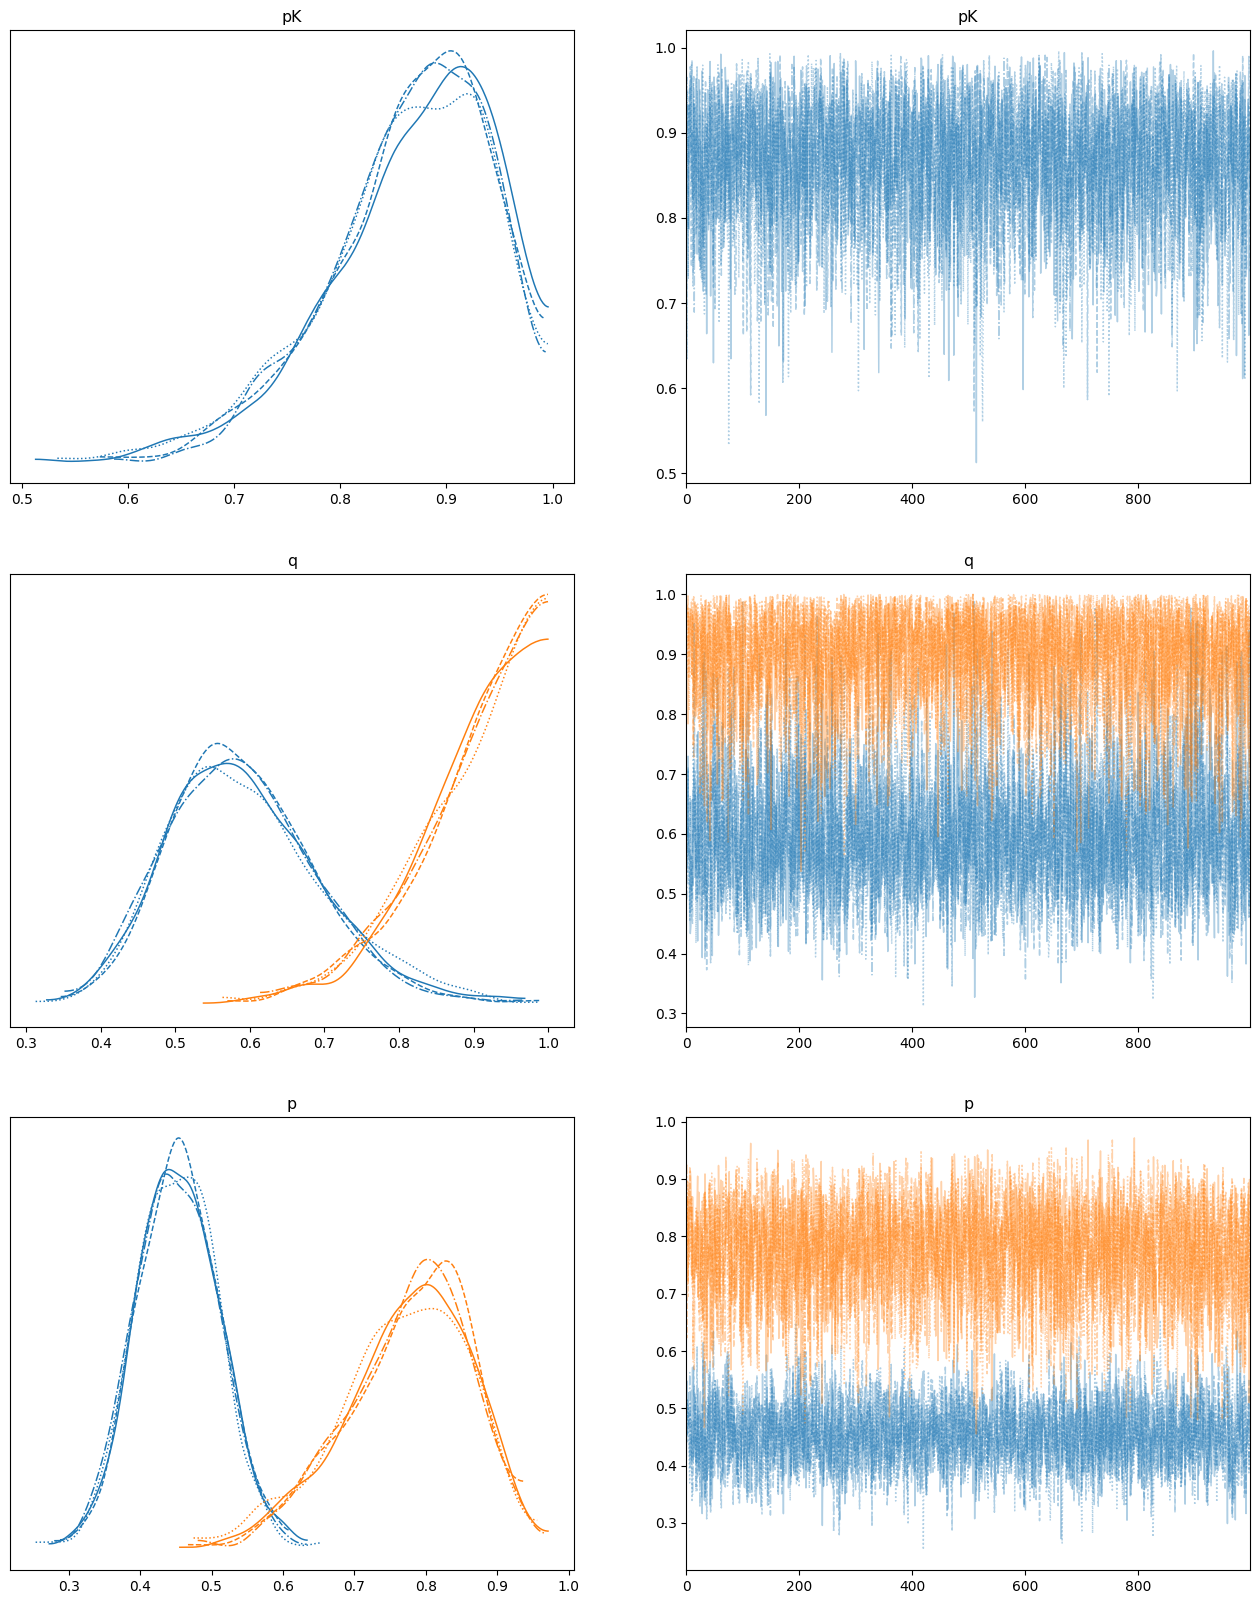

In [ ]:
params = ['p3', 'p2', 'p1']

# for param in params:
#     ess = az.ess(model4_df[param].values)
#     print(f'Effective sample size of {ess} for parameter {param}')

az.plot_trace(model4_samples, figsize=(16,20))
# sns.pairplot(model4_df[['p3', 'p2', 'p1']])
plt.show()

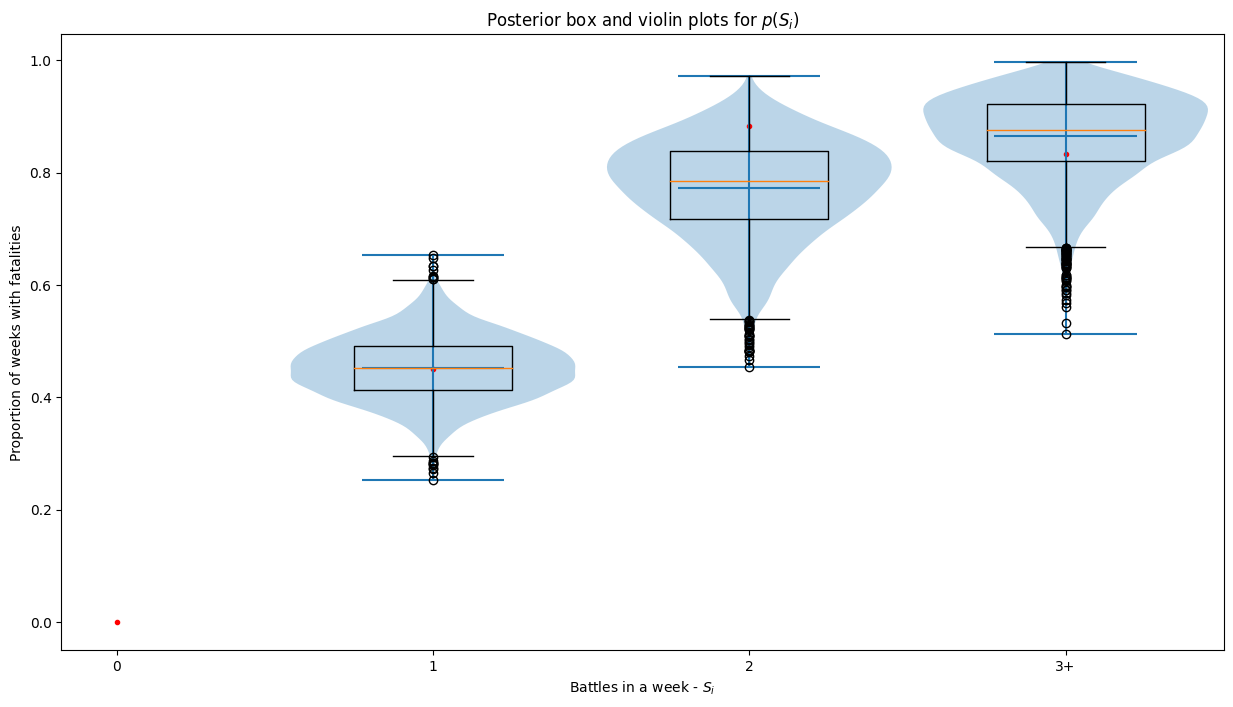

In [ ]:
sim_battles = [0, 1, 2, 3]

fig, ax = plt.subplots(figsize = (15, 8))

probabilities = model4_df[['p.1', 'p.2', 'pK']].values
ax.set(title=rf'Posterior box and violin plots for $p(S_i)$',
          xlabel = r'Battles in a week - $S_i$',
          ylabel = 'Proportion of weeks with fatalities')

for i in range(6):
    total = len(dhaka_battles.loc[dhaka_battles['BINS'] == i])
    fatal = len(dhaka_battles.loc[dhaka_battles['BINS'] == i].loc[dhaka_battles['BOOLEAN_FATAL'] == 1])
    if total != 0:
        ax.plot(i, fatal/total, 'r.', label='observed')

ax.violinplot(probabilities, widths=0.9, showmeans=True, positions=sim_battles[1:])
ax.boxplot(probabilities, widths=0.5, positions=sim_battles[1:])

x_labels = ['0', '1', '2', '3+']
plt.xticks([0, 1, 2, 3], x_labels)

plt.show()

In [ ]:
filter_dict = {'ADM2_name':'Dhaka', 'EVENT_TYPE':'Battles'}

mask = pd.Series(True, index=data.index)

for key, value in filter_dict.items():
    mask &= (data[key] == value)

filtered_data = data[mask]

filtered_data

,ISO3C,Country,ADM2_code,ADM2_name,ADMIN1,AREA_km2,LONGITUDE,LATITUDE,POPULATION,POP_POLYONLY,EVENT_COUNTS,EVENT_COUNTS_POLYONLY,RAW_COUNTS,FATALITIES,EVENT_TYPE,YEAR,DAY,DATE,MONTH,WEEK
17,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.180957e+07,1.180957e+07,1.0,1.0,1.0,0.0,Battles,2010.0,1.0,2010-01-01,2010-01,2009-12-28/2010-01-03
401,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.180957e+07,1.180957e+07,0.0,0.0,0.0,0.0,Battles,2010.0,2.0,2010-01-02,2010-01,2009-12-28/2010-01-03
785,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.180957e+07,1.180957e+07,0.0,0.0,0.0,0.0,Battles,2010.0,3.0,2010-01-03,2010-01,2009-12-28/2010-01-03
1169,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.180957e+07,1.180957e+07,0.0,0.0,0.0,0.0,Battles,2010.0,4.0,2010-01-04,2010-01,2010-01-04/2010-01-10
1553,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.180957e+07,1.180957e+07,0.0,0.0,0.0,0.0,Battles,2010.0,5.0,2010-01-05,2010-01,2010-01-04/2010-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681169,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.585799e+07,1.585799e+07,0.0,0.0,0.0,0.0,Battles,2021.0,361.0,2021-12-27,2021-12,2021-12-27/2022-01-02
1681553,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.585799e+07,1.585799e+07,0.0,0.0,0.0,0.0,Battles,2021.0,362.0,2021-12-28,2021-12,2021-12-27/2022-01-02
1681937,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.585799e+07,1.585799e+07,0.0,0.0,0.0,0.0,Battles,2021.0,363.0,2021-12-29,2021-12,2021-12-27/2022-01-02
1682321,BGD,Bangladesh,BGD.3.1_1,Dhaka,Dhaka,1479.481674,90.250781,23.786896,1.585799e+07,1.585799e+07,0.0,0.0,0.0,0.0,Battles,2021.0,364.0,2021-12-30,2021-12,2021-12-27/2022-01-02
